<a href="https://colab.research.google.com/github/vacheharutyunyan/machine-learning-projects/blob/main/housing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/Housing.csv")
df.head()


Path to dataset files: /root/.cache/kagglehub/datasets/harishkumardatalab/housing-price-prediction/versions/1


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [21]:
df.shape

(545, 13)

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0


In [23]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [24]:
df.duplicated().sum()

np.int64(0)

In [25]:
df.dtypes.value_counts()

,count
object,7
int64,6


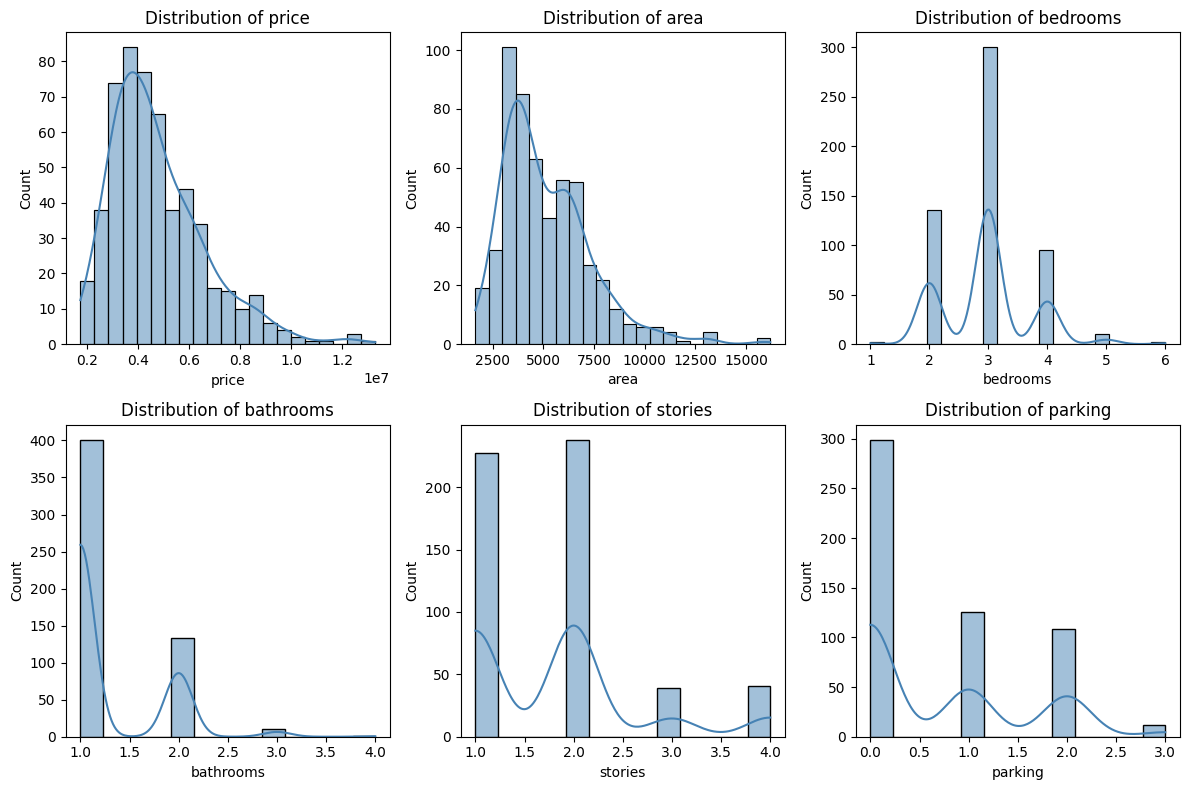

In [26]:
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, color='steelblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


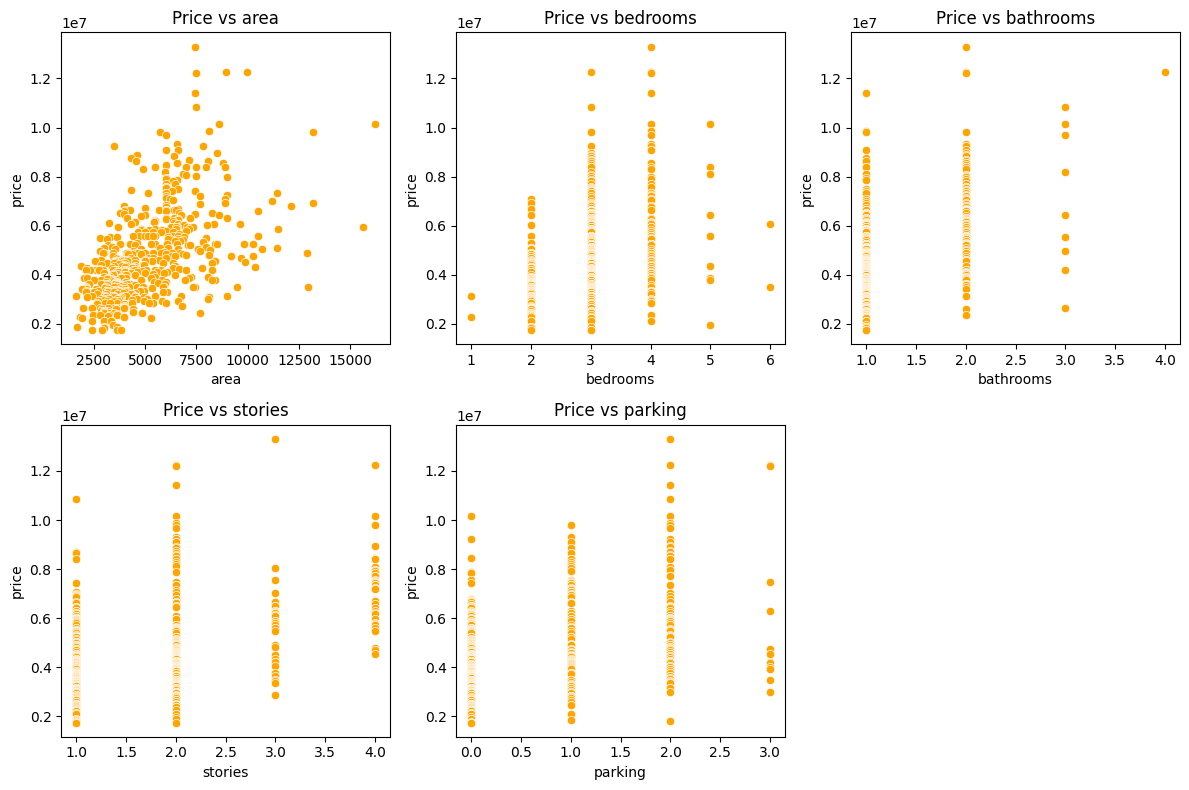

In [27]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[1:], 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[col], y=df['price'], color='orange')
    plt.title(f"Price vs {col}")
plt.tight_layout()
plt.show()


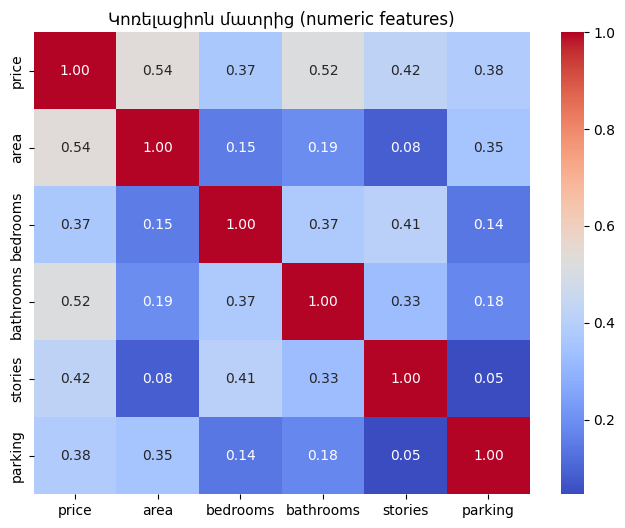

In [28]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Կոռելացիոն մատրից (numeric features)")
plt.show()


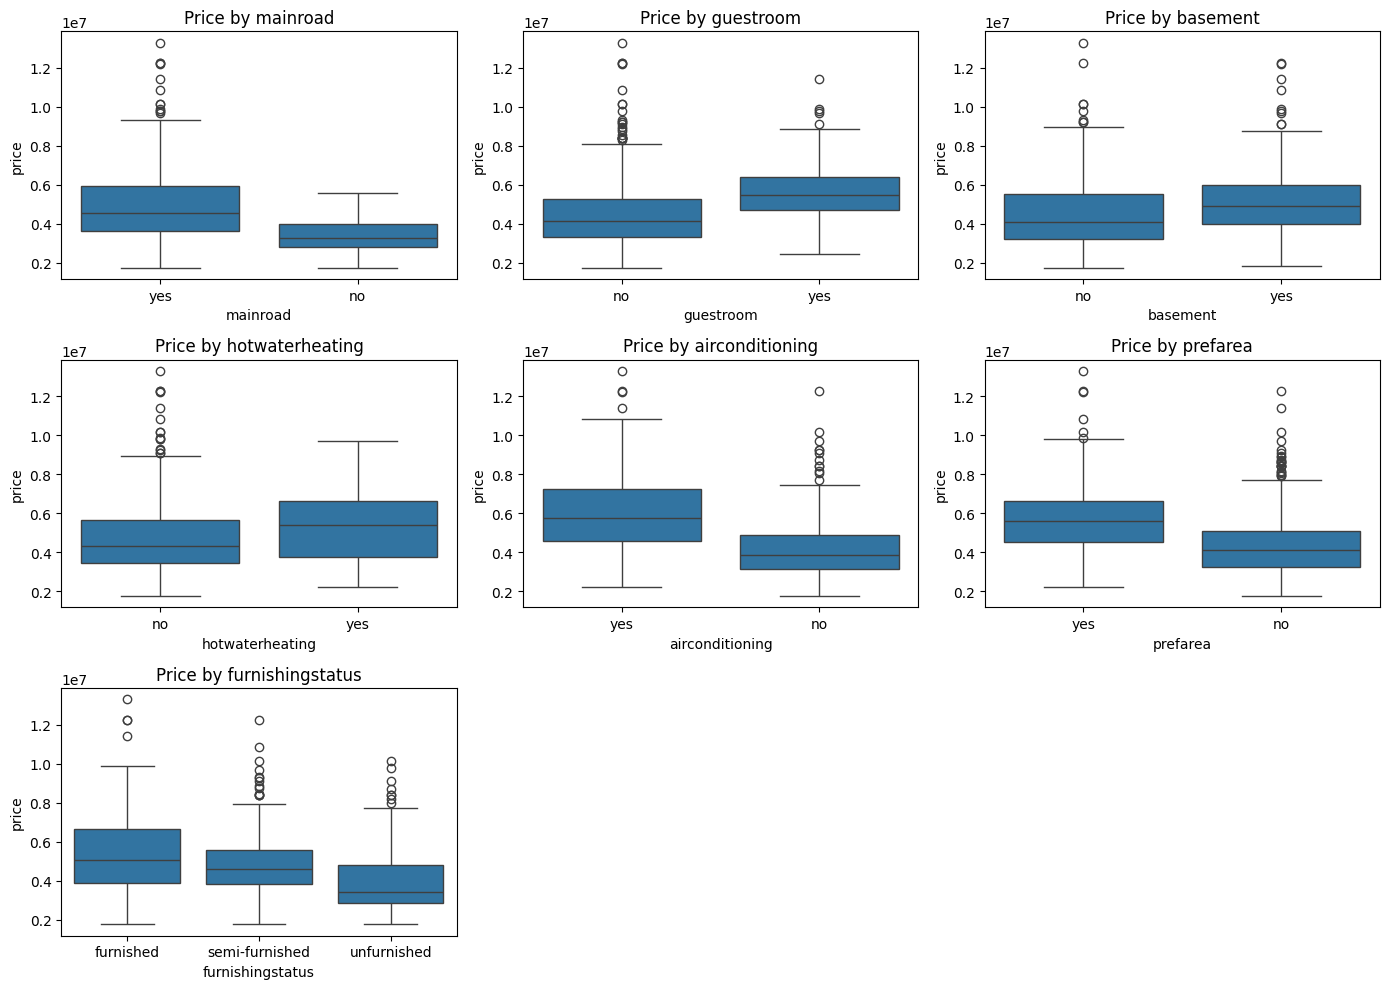

In [29]:
categorical_cols = ['mainroad', 'guestroom', 'basement',
                    'hotwaterheating', 'airconditioning',
                    'prefarea', 'furnishingstatus']

plt.figure(figsize=(14,10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], y=df['price'])
    plt.title(f"Price by {col}")
plt.tight_layout()
plt.show()


In [30]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
print("Original shape:", df.shape)
print("Filtered shape:", df_filtered.shape)


Original shape: (545, 13)
Filtered shape: (530, 13)


<Axes: xlabel='price', ylabel='Count'>

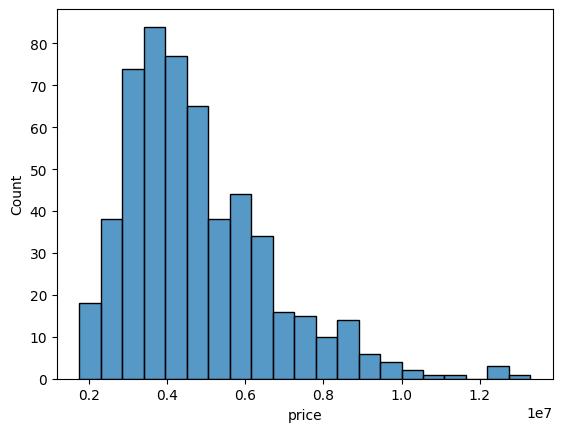

In [31]:
sns.histplot(x = df['price'])

Text(0.5, 1.0, 'Log-transformed Price Distribution')

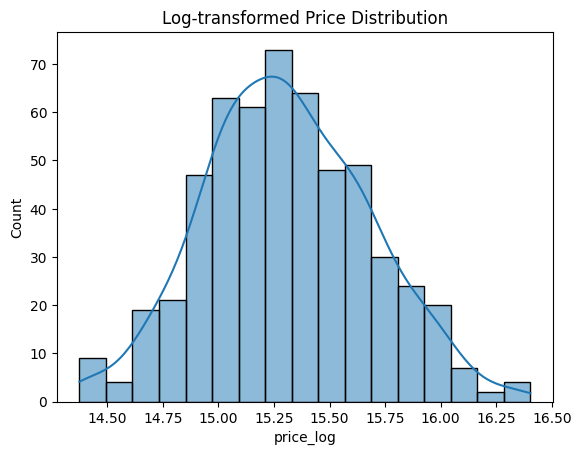

In [32]:
df['price_log'] = np.log1p(df['price'])
sns.histplot(df['price_log'], kde=True)
plt.title("Log-transformed Price Distribution")


In [33]:

df_encoded = df.copy()

binary_cols = ['mainroad', 'guestroom', 'basement',
               'hotwaterheating', 'airconditioning', 'prefarea']

for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({'yes': 1, 'no': 0})

df_encoded = pd.get_dummies(df_encoded, columns=['furnishingstatus'], drop_first=True)

df_encoded.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,price_log,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,16.403275,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,16.321037,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,16.321037,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,16.318175,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,16.250001,False,False


In [37]:
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 371001.39
RMSE: 590259.44
R²: 0.931
